In [1]:
import h5py
import numpy
import os

In [2]:
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import colormaps as cm

In [3]:
from utils.path import RAW_IP
from utils import file

In [4]:
rawX = file.LoadTiff(os.path.join(RAW_IP, '19920612_AVIRIS_IndianPine_Site3.tif'))
rawY = file.LoadTiff(os.path.join(RAW_IP, '19920612_AVIRIS_IndianPine_Site3_gr.tif'))
rawTrY = file.LoadTiff(os.path.join(RAW_IP, 'indianpines_ts.tif'))

/home/xdrl1/miniconda3/envs/hsidata/lib/python3.10/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
name2IdxPurdue = {
    "Alfalfa": 1, 
    "Corn-notill": 2,
    "Corn-min": 3,
    "Corn": 4,
    "Grass/Pasture": 5,
    "Grass/Trees": 6,
    "Grass/pasture-mowed": 7,
    "Hay-windrowed": 8, 
    "Oats": 9,
    "Soybeans-notill": 10,
    "Soybeans-min": 11,
    "Soybean-clean": 12,
    "Wheat": 13,               
    "Woods": 14,                
    "Bldg-Grass-Tree-Drives": 15,
    "Stone-steel towers": 16    
}

name2IdxDASE = {
    "Alfalfa": 10, 
    "Corn-notill": 1,
    "Corn-min": 2,
    "Corn": 11,
    "Grass/Pasture": 3,
    "Grass/Trees": 4,
    "Grass/pasture-mowed": 12,
    "Hay-windrowed": 5, 
    "Oats": 13,
    "Soybeans-notill": 6,
    "Soybeans-min": 7,
    "Soybean-clean": 8,
    "Wheat": 14,               
    "Woods": 9,                
    "Bldg-Grass-Tree-Drives": 15,
    "Stone-steel towers": 16    
}

In [6]:
nbgMask = rawY != 0  # non-background
trMask = rawTrY != 0

In [7]:
vaMask = (nbgMask.astype(int) - trMask.astype(int)).astype(bool)

In [8]:
print('#pixels for training for every category:\n')
print(f"{_:>26}Purdue\tIEEE DASE")
for plant in name2IdxPurdue.keys():
    print(f"{plant:>24}: {(rawY[trMask]==name2IdxPurdue[plant]).sum()}\t\t{(rawTrY==name2IdxDASE[plant]).sum()}")

#pixels for training for every category:

                          Purdue	IEEE DASE
                 Alfalfa: 29		29
             Corn-notill: 762		762
                Corn-min: 435		435
                    Corn: 146		146
           Grass/Pasture: 232		232
             Grass/Trees: 394		394
     Grass/pasture-mowed: 26		16
           Hay-windrowed: 235		235
                    Oats: 10		10
         Soybeans-notill: 470		470
            Soybeans-min: 1414		1424
           Soybean-clean: 328		328
                   Wheat: 132		132
                   Woods: 728		728
  Bldg-Grass-Tree-Drives: 291		291
      Stone-steel towers: 57		57


Clearly, after we apply the training mask provided by IEEE DASE, there are 10 pixels less for `Grass/pasture-mowed`, and exactly 10 pixels more for `Soybeans-min`, which means there are 10 `Grass/pasture-mowed` pixels wrongly labeled as training samples for `Soybeans-min`. We can clearly see this problem by visualization.

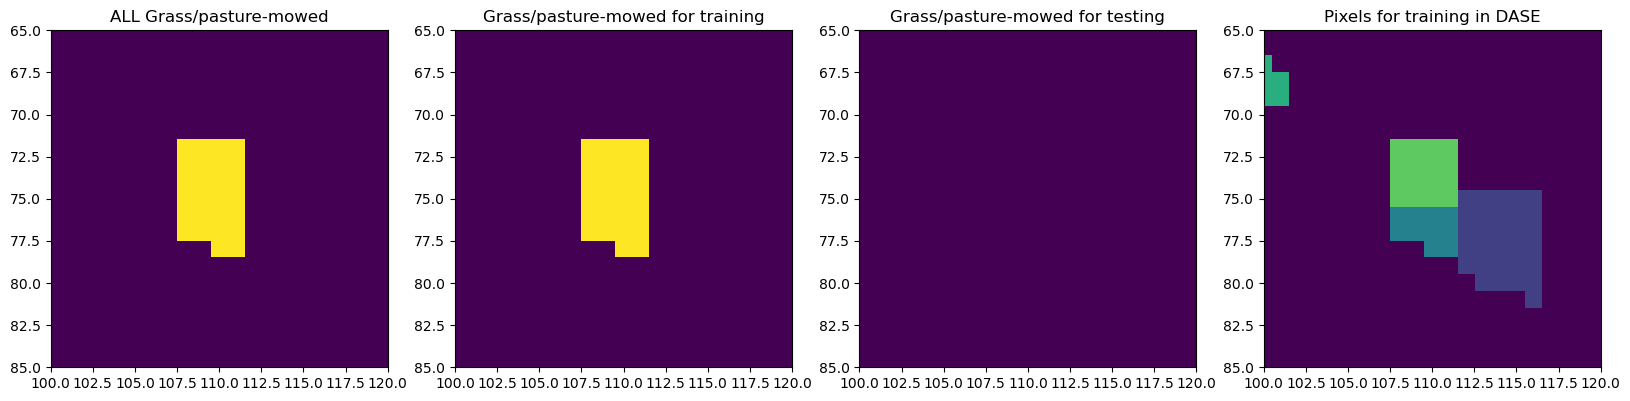

In [9]:
plt.figure(figsize=(20, 6))
plt.subplot(141)
plt.title('ALL Grass/pasture-mowed')
plt.imshow((rawY==name2IdxPurdue['Grass/pasture-mowed']))
plt.xlim([100, 120])
plt.ylim([85, 65])
plt.subplot(142)
plt.title('Grass/pasture-mowed for training')
plt.imshow(numpy.multiply(rawY, trMask)==name2IdxPurdue['Grass/pasture-mowed'])
plt.xlim([100, 120])
plt.ylim([85, 65])
plt.subplot(143)
plt.title('Grass/pasture-mowed for testing')
plt.imshow(numpy.multiply(rawY, vaMask)==name2IdxPurdue['Grass/pasture-mowed'])
plt.xlim([100, 120])
plt.ylim([85, 65])
plt.subplot(144)
plt.title('Pixels for training in DASE')
# plt.imshow(rawTrY==name2IdxDASE['Soybeans-min'])
plt.imshow(rawTrY)
plt.xlim([100, 120])
plt.ylim([85, 65])
plt.show()

All 26 pixels of `Grass/pasture-mowed` are labeled for training, thus no pixels for testing. Clearly, 10 pixels at 

- x: 108, 109, 110, 111, 108, 109, 110, 111, 110, 111
- y:  76,  76,  76,  76,  77,  77,  77,  77,  78,  78

are wrongly labeled as `Soybeans-min` for training. We can simply solve this problem by making these 10 pixels for testing by modifying the `trMask`.

In [10]:
# fix
trMask[76][108:112] = False
trMask[77][108:112] = False
trMask[78][110:112] = False
vaMask = (nbgMask.astype(int) - trMask.astype(int)).astype(bool)  # do not forget to update vaMask

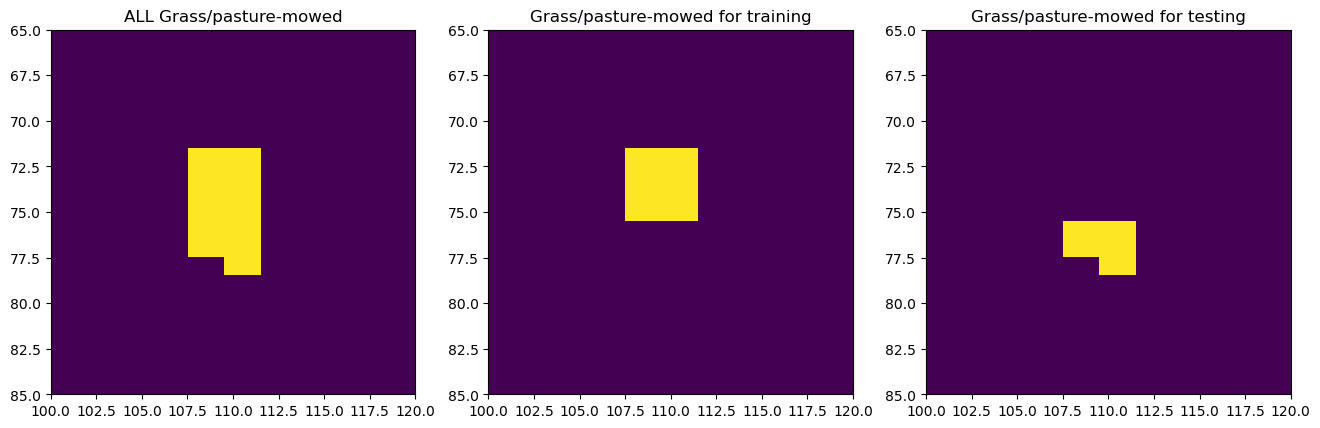

In [11]:
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.title('ALL Grass/pasture-mowed')
plt.imshow((rawY==name2IdxPurdue['Grass/pasture-mowed']))
plt.xlim([100, 120])
plt.ylim([85, 65])
plt.subplot(132)
plt.title('Grass/pasture-mowed for training')
plt.imshow(numpy.multiply(rawY, trMask)==name2IdxPurdue['Grass/pasture-mowed'])
plt.xlim([100, 120])
plt.ylim([85, 65])
plt.subplot(133)
plt.title('Grass/pasture-mowed for testing')
plt.imshow(numpy.multiply(rawY, vaMask)==name2IdxPurdue['Grass/pasture-mowed'])
plt.xlim([100, 120])
plt.ylim([85, 65])
plt.show()

In this way, for `Grass/pasture-mowed`, pixels for training and testing exist and are disjoint. The number of all/training/test pixels for all categories are listed below.

In [12]:
print('Basic statistics for Indian Pines:\n')
print(f"{_:>32}#all\t#train\t#test")
for plant in name2IdxPurdue.keys():
    print(f"{plant:>24}:\t{(rawY==name2IdxPurdue[plant]).sum()}\t{(rawY[trMask]==name2IdxPurdue[plant]).sum()}\t{(rawY[vaMask]==name2IdxPurdue[plant]).sum()}")

Basic statistics for Indian Pines:

                                #all	#train	#test
                 Alfalfa:	54	29	25
             Corn-notill:	1434	762	672
                Corn-min:	834	435	399
                    Corn:	234	146	88
           Grass/Pasture:	497	232	265
             Grass/Trees:	747	394	353
     Grass/pasture-mowed:	26	16	10
           Hay-windrowed:	489	235	254
                    Oats:	20	10	10
         Soybeans-notill:	968	470	498
            Soybeans-min:	2468	1414	1054
           Soybean-clean:	614	328	286
                   Wheat:	212	132	80
                   Woods:	1294	728	566
  Bldg-Grass-Tree-Drives:	380	291	89
      Stone-steel towers:	95	57	38


Now we can save the dataset.

(-0.5, 144.5, 144.5, -0.5)

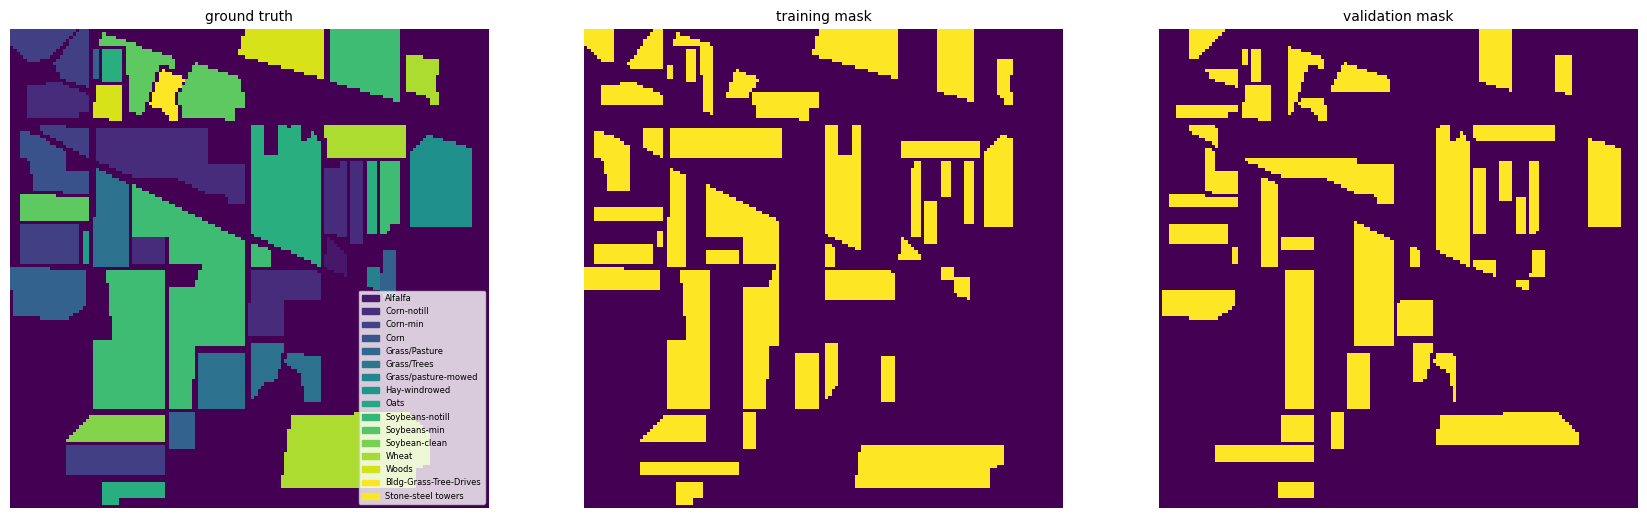

In [17]:
name2Idx = name2IdxPurdue
plt.figure(figsize=(21, 12))
plt.subplot(131)
plt.imshow(rawY, cmap='viridis')
cmap = cm['viridis'].resampled(len(name2Idx))
patches =[mpatches.Patch(color=cmap(name2Idx[land]), label=land) for land in name2Idx.keys()]
plt.legend(handles=patches, prop={'size': 6}, loc='lower right')
plt.title('ground truth', fontsize=10)
plt.axis('off')
plt.subplot(132)
plt.imshow(trMask)
plt.title('training mask', fontsize=10)
plt.axis('off')
plt.subplot(133)
plt.imshow(vaMask)
plt.title('validation mask', fontsize=10)
plt.axis('off')

In [14]:
print(rawX.shape, rawY.shape, trMask.shape, vaMask.shape)
with h5py.File('../IndianPines.h5', 'w') as h5w:
    h5w.create_dataset('HSI', data=rawX)
    h5w.create_dataset('gt', data=rawY)
    h5w.create_dataset('trMask', data=trMask)
    h5w.create_dataset('vaMask', data=vaMask)

(220, 145, 145) (145, 145) (145, 145) (145, 145)
